In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import umap
# import ipyvolume as ipv
import os, requests
import time

from tqdm.notebook import tqdm
from scipy import stats

## Data retrieval

In [ ]:
#@title Data retrieval
import os, requests

fname = []

for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
    
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)


### Importing spike-train data

In [ ]:
# importing spike-train data (we need bins = 1 ms for HMM instead of 10 ms)

filename = 'steinmetz_st.npz'

url = "https://osf.io/4bjns/download"

if not os.path.isfile(filename):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(filename, "wb") as fid:
                fid.write(r.content)

In [5]:
## DO NOT TOUCH ONCE LOADED ----- !! High RAM consumption !! 

dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

In [7]:
# Pick up one session
print("Number of sessions: {}".format(dat_ST.shape[0]))

session = 10
data = dat_ST[session]['ss']

# print("Total number of trials (for every session): {}".format(total_trials))
print("N neurons: {}".format(data.shape[0]))
print("M trials (for {}-th session): {}".format(session, data.shape[1]))
print()
# ???
print("Data shape is thus (n_neurons, n_trials) = ({}, {})".format(*data.shape))

n_neurons = data.shape[0]
n_trials = data.shape[1]

Number of sessions: 39
N neurons: 857
M trials (for 10-th session): 342

Data shape is thus (n_neurons, n_trials) = (857, 342)


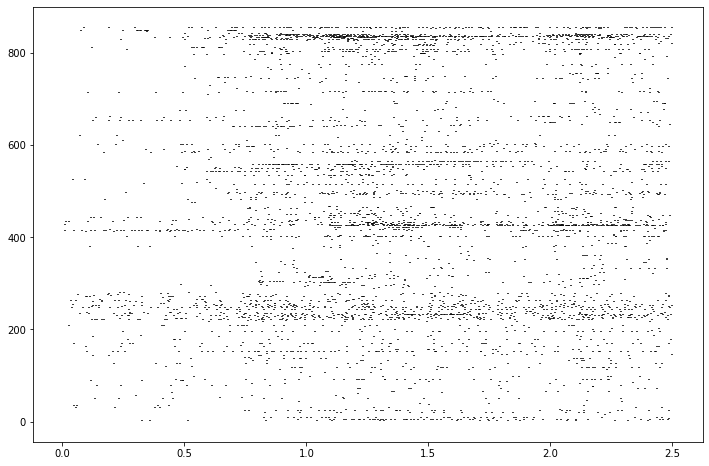

In [8]:
# visualize session data for i-th trial

i_trial = 0

fig, ax = plt.subplots(figsize=(12, 8))

ax.eventplot(data[:, i_trial], color='black' )

plt.show()

### Data preprocessing

In [16]:
def bin_1trial_1neuron_data(data, i_neuron, i_trial, dt=0.001, T=2.5):
    """
    Bins data for neuron #i, trial #i 
    in bins with length = dt, total trial time = T
    """
    bins = np.arange(0., T + dt, dt)
    spikes, t = np.histogram(data[i_neuron][i_trial], bins) # Binning spikes into dt (ms) bins
    spikes[spikes > 1] = 1 # Assuming <=1 spike in the time bin
    return spikes, t
    
def bin_1trial_data(data, i_neurons, i_trial, dt=0.001, T=2.5):
    """
    Bins data for neurons of  № = [neuron_1_idx, neuron_2_idx, ...] 
    in bins with length = dt, total time = T
    
    returns array of shape (len(i_neurons), len(trial) in units of dt)
    """
    nbins = len(np.arange(0., T + dt, dt)) - 1
    binned_data = np.zeros(nbins).reshape((1, nbins)) # add zero-valued row to use vstack
    
    for i_neuron in i_neurons:
        binned_data = np.vstack((binned_data, bin_1trial_1neuron_data(data, i_neuron, i_trial)[0]))
    binned_data = np.delete(binned_data, 0, 0) # remove first zero-valued row
    
    # TODO: here we should implement that there should be 
    # no more than two spikes (of different neurons) in one time bin
    
    return binned_data

def bin_data(data, dt=0.001, T=2.5):
    """
    Bins spiking data in dt bins, converts in a shape (n_trials, T, n_neurons)
    Input shape = (n_neurons, n_trials, var_size)
    """
    print("Data shape: {}".format(data.shape))
    n_neurons = data.shape[0]
    n_trials = data.shape[1]
    i_neurons = np.arange(n_neurons) # All neurons

    binned_data = np.array([bin_1trial_data(data, i_neurons, i_trial, dt, T).reshape((-1, n_neurons)) \
                           for i_trial in tqdm(range(n_trials))])
    # reshape for shape (T, n_neurons)
    
    # Make sure there is no simultenous firing of >= 2 neurons in one timestep
    # eliminate_multiple_spikes(binned_data) # TODO
    
    print("Binned data shape: {}".format(binned_data.shape))
    
    return binned_data.astype('int')

def eliminate_multiple_spikes(binned_data):
    """
    ------TODO------
    Makes sure there is no simultenous firing of >= 2 neurons in one timestep
    Input shape = (n_trials, T, n_neurons)
    """
    pass # to clear when done

    t_idx = np.sum(binned_data, axis=2) > 1
    
    for t in t_idx:
        neurons_idx = (binned_data[:, t_idx] == 1)
        # choose which neuron fires randomly
        
        binned_data[:, t_idx] = np.zeros_like(binned_data[:, t_idx])
        
    
    

In [10]:
A = np.arange(16).reshape((4, 4))

A % 3 == 0

array([[ True, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [ True, False, False,  True]])

In [11]:
def obtain_firing_rate(data, i_neuron, stat_for_trials=np.max, T=2.5):
    """
    Obtains single neuron FR for all trials
    Required data type: times of spikes
    """
    n_trials = data.shape[1]
    firing_rates_for_trials = np.array([len(data[i_neuron][i_trial]) / T for i_trial in range(n_trials)])
    
    return stat_for_trials(firing_rates_for_trials)

def find_silent_neurons(data, threshold = 2):
    """
    Finds spike indexes firing less frequent then theshold value (in Hz)
    Required data type: times of spikes
    """
    silent_neurons_idx = []
    ok_neurons_idx = []
    for i_neuron in range(data.shape[0]):
        if obtain_firing_rate(data, i_neuron, stat=np.max, T=2.5) < threshold:
            silent_neurons_idx.append(i_neuron)
        else:
            ok_neurons_idx.append(i_neuron)
    return silent_neurons_idx, ok_neurons_idx

def exclude_silent_neurons(data):
    """
    
    """
    n_neurons = data.shape[0]
    silent_idx, ok_idx = find_silent_neurons(data)
    data = data[ok_idx]
    return data
    

In [12]:
mean_firing_rates = np.array([obtain_firing_rate(data, i_neuron, np.mean) for i_neuron in range(n_neurons)])

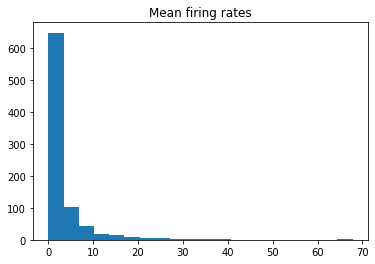

Max firing rate: 67.8


In [13]:
plt.hist(mean_firing_rates, bins=20)
plt.title("Mean firing rates")
plt.show()
max_firing_rate = np.max(mean_firing_rates)
print(f"Max firing rate: {max_firing_rate:.3}")

In [17]:
%%time

# binning spiking data to array of 0, 1 (dt = 1ms)
binned_data = bin_data(data)

Data shape: (857, 342)



Binned data shape: (342, 2500, 857)
Wall time: 21min 20s


In [18]:
# float64 -> int

binned_data = binned_data.astype('int')

### General HMM pipeline (PLAN)

1. Preload and preprocess data: 
    * exclude low-spiking neurons (< threshold)
    * 1 ms bins
    * ensure there is not more than 1 spike (of any neuron) in one time bin

2. Determine the Poisson HMM Model (Luca 2015): 
    * determine observation probabilities
    * determine transition probabilities (Aij)
    

First let's assume number of hidden states is K = 10

#### Expectation maximization (EM) backward-forward algorithm

In [19]:
def e_step(Y, psi, A, L, dt):
    """Calculate the E-step for the HMM spiking model.

    Args:
    Y (numpy 3d array): tensor of recordings, has shape (n_trials, T, C)
    psi (numpy vector): initial probabilities for each state
    A (numpy matrix):   transition matrix, A[i,j] represents the prob to
                        switch from i to j. Has shape (K,K)
    L (numpy matrix):   Poisson rate parameter for different cells.
                        Has shape (C,K)
    dt (float):         Bin length

    Returns:
    ll (float):             data log likelihood
    gamma (numpy 3d array): singleton marginal distribution.
                            Has shape (n_trials, T, K)
    xi (numpy 4d array):    pairwise marginal distribution for adjacent
                            nodes . Has shape (n_trials, T-1, K, K)
    """
    n_trials = Y.shape[0]
    T = Y.shape[1]
    K = psi.size
    log_a = np.zeros((n_trials, T, K))
    log_b = np.zeros((n_trials, T, K))

    log_A = np.log(A)
    
    #print("Extracting Poisson observations")
    log_obs = stats.poisson(L * dt).pmf(Y[..., None]).sum(-2)  # (n_trials, T, K)

    # forward pass
    #print("Starting forward pass calculation")
    log_a[:, 0] = log_obs[:, 0] + np.log(psi)
    for t in range(1, T):
        tmp = log_A + log_a[:, t - 1, : ,None]  # (n_trials, K,K)
        maxtmp = tmp.max(-2)  # (n_trials,K)
        log_a[:, t] = (log_obs[:, t] + maxtmp + np.log(np.exp(tmp - maxtmp[:, None]).sum(-2)))

    # backward pass
    #print("Starting backward pass calculation")
    for t in range(T - 2, -1, -1):
        tmp = log_A + log_b[:, t + 1, None] + log_obs[:, t + 1, None]
        maxtmp = tmp.max(-1)
        log_b[:, t] = maxtmp + np.log(np.exp(tmp - maxtmp[..., None]).sum(-1))

    # data log likelihood 
    maxtmp = log_a[:, -1].max(-1)
    ll = np.log(np.exp(log_a[:, -1] - maxtmp[:, None]).sum(-1)) + maxtmp

    # singleton and pairwise marginal distributions 
    gamma = np.exp(log_a + log_b - ll[:, None, None])
    xi = np.exp(log_a[:, :-1, :, None] + (log_obs + log_b)[:, 1:, None] + log_A - ll[:, None, None, None])

    return ll.mean() / T / dt, gamma, xi

In [20]:
def m_step(Y, gamma, xi, dt):
    """Calculate the M-step updates for the HMM spiking model.

    Args:
    gamma ():       Number of epochs of EM to run
    xi (numpy 3d array): Tensor of recordings, has shape (n_trials, T, C)
    dt (float):         Duration of a time bin

    Returns:
    psi_new (numpy vector): Updated initial probabilities for each state
    A_new (numpy matrix):   Updated transition matrix, A[i,j] represents the
                        prob. to switch from j to i. Has shape (K,K)
    L_new (numpy matrix):   Updated Poisson rate parameter for different
                        cells. Has shape (C,K)
    """
    psi_new = np.mean(gamma[:, 0], axis=0)
    # Make sure the probabilities are normalized
    psi_new /= psi_new.sum()

    # Calculate new transition matrix
    A_new = xi.sum(axis=(0, 1)) / gamma[:, :-1].sum(axis=(0, 1))[:, np.newaxis]
    # Calculate new firing rates
    L_new = (np.swapaxes(Y, -1, -2) @ gamma).sum(axis=0) / gamma.sum(axis=(0, 1)) / dt
    
    return psi_new, A_new, L_new

### Training HMM

In [21]:
n_trials_test = 20

test_data = binned_data[:n_trials_test]  # shape = (n_trials, T, n_neurons)

In [22]:
# initializing (random) model params: A (transition probs), psi (initial state probs), L (emission probs)

# number of neurons = N

n_neurons = test_data.shape[2]

# number of hidden states = K
k_states = 10

trial_T = 2.5
dt = 0.001

T = round(trial_T / dt)
ts = np.arange(T)

# initial state distribution
psi = np.arange(1, k_states + 1)
psi = psi / psi.sum()

# off-diagonal transition rates sampled uniformly

max_transition_rate = 20 # Hz

A = np.random.rand(k_states, k_states) * max_transition_rate * dt
A = (1. - np.eye(k_states)) * A
A = A + np.diag(1 - A.sum(1))

# emission probabilities (shape = (N_neurons, K_states))
L = np.random.rand(n_neurons, k_states) * max_firing_rate

In [23]:
%%time

n_trains = 5

psi_new, A_new, L_new = psi, A, L

for i in tqdm(range(n_trains)):
    ll, gamma, xi = e_step(test_data, psi_new, A_new, L_new, dt)
    psi_new, A_new, L_new = m_step(test_data, gamma, xi, dt)
    
ll, gamma, xi = e_step(test_data, psi_new, A_new, L_new, dt)


Wall time: 4min 31s


### HMM Decoding state sequence

Choose trial, for each timestep t compute (arg)maximum of the gamma(i_trial, t, :)

[[0.94  0.014 0.006 0.008 0.001]
 [0.006 0.89  0.013 0.019 0.017]
 [0.02  0.007 0.92  0.019 0.005]
 [0.013 0.005 0.001 0.92  0.001]
 [0.    0.008 0.017 0.007 0.928]]


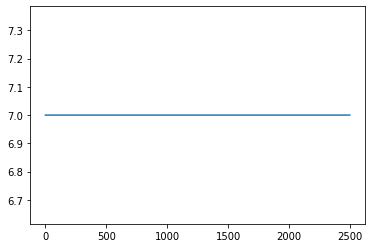

In [24]:
i_trial = 10

state_sequence = np.argmax(gamma[i_trial], axis=1)

print(np.around(A[:5, :5], 3))

plt.plot(state_sequence)

#### Each step again for different number of states:
1. Initialize model -> set K, psi, A, L
2. Train model -> compute ll, gamma, xi; retain new model params

In [25]:
n_steps = 15

k_states_list = range(5, 5 + n_steps)

ll_list, gamma_list, xi_list = [], [], []
psi_list, A_list, L_list = [], [], []
# Some lists will contain np.arrays of different shapes (because of varying k_states)

test_data = binned_data[:n_trials_test]

# iterating over k_states = (5, 6, ... 29)
for i in tqdm(range(n_steps)):
    
    """ STEP 1: Initializing """

    # number of neurons
    n_neurons = test_data.shape[2]

    # number of hidden states
    k_states = k_states_list[i]

    trial_T = 2.5
    dt = 0.001

    T = round(trial_T / dt)
    ts = np.arange(T)

    # initial state distribution, random set each time
    # shape = (K_states)
    psi = np.random.rand(k_states)
    psi = psi / psi.sum()

    # transition matrix A; off-diagonal transition rates sampled uniformly
    # shape = (K_states, K_states)

    max_transition_rate = 20 # Hz

    A = np.random.rand(k_states, k_states) * max_transition_rate * dt
    A = (1. - np.eye(k_states)) * A
    A = A + np.diag(1 - A.sum(1))

    # emission probabilitiesl sampled randomly 
    # (shape = (N_neurons, K_states))
    L = np.random.rand(n_neurons, k_states) * max_firing_rate
    
    """ STEP 2: Training """
    
    n_trains = 5

    psi_new, A_new, L_new = psi, A, L
    for i in range(n_trains):
        ll, gamma, xi = e_step(test_data, psi_new, A_new, L_new, dt)
        psi_new, A_new, L_new = m_step(test_data, gamma, xi, dt)

    ll, gamma, xi = e_step(test_data, psi_new, A_new, L_new, dt)
    
    # adding obtained values to lists
    ll_list.append(ll)
    gamma_list.append(gamma)
    xi_list.append(xi)
    
    psi_list.append(psi_new)
    A_list.append(A_new)
    L_list.append(L_new)
    
# TODO: find model with maximal loglikelihood, use its params to generate state sequence

In [30]:
model_idx = np.argmax(ll_list)

model_idx

4

[[0.793 0.019 0.016 0.013 0.   ]
 [0.002 0.832 0.012 0.014 0.006]
 [0.    0.001 0.823 0.013 0.008]
 [0.019 0.003 0.006 0.839 0.007]
 [0.003 0.013 0.008 0.015 0.796]]


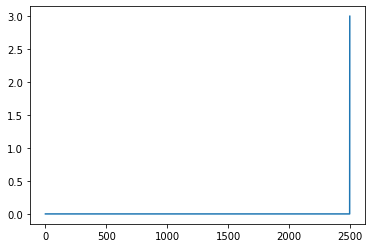

In [44]:
gamma = gamma_list[4]

i_trial = 15

state_sequence = np.argmax(gamma[i_trial], axis=1)

print(np.around(A[:5, :5], 3))

plt.plot(state_sequence)

## Function for neuron selection

In [27]:
def neurons_from_area(area, alldat, neuron_type='exc'):
    # neuron_type: 'exc' - firing rate increase after stimulation, 'inh' -- decrease, 'all' -- all
    
    V1stim_neurons_rec = []
    stim_neurons_rec = []
    
    for record in range(len(alldat)):
        
        dat = alldat[record]
        V1_stim_neurons = []
        stim_neurons = []
        
        times = np.arange(0, 2.5, 0.01) # recording times
        
        nogo_trials = []
        for i in range(dat['spks'].shape[1]):
            if dat['contrast_left'][i] == 0 and dat['contrast_right'][i] == 0:
                nogo_trials.append(i)
        
        for i_neuron in range(dat['spks'].shape[0]):
            
            prestim = [] # intervals before the stimulus onset
            poststim = [] # intervals from stimulus onset to mouse response

            for trial in range(dat['spks'].shape[1]):
      
                # exclude NoGo trials
                if trial not in nogo_trials:
                    
                    # 0.5 sec - time of visual stimulus onset
                    # gocue - is auditory stimulus, which usually follows the visual one
                    if dat['gocue'][trial] > 0.5:
                        cue = dat['gocue'][trial]
                    else:
                        cue = 0.5
                    resp = dat['response_time'][trial]

                    # time index of stimulus onset
                    cue_i = (np.abs(times - cue)).argmin()

                    # time index of response
                    resp_i = (np.abs(times - resp)).argmin()

                    # append number of spikes normalized by a time period ("frequency")
                    prestim.append(np.sum(dat['spks'][i_neuron, trial, :cue_i]) / times[cue_i-1])
                    poststim.append(np.sum(dat['spks'][i_neuron, trial, cue_i:resp_i]) / (times[resp_i]-times[cue_i]))
        

            # exclude nan values from lists (часототы для данного нейрона на разных триалах до и после стимуляции)
            prestim = [pr for pr in prestim if str(pr) != 'nan']
            poststim = [pr for pr in poststim if str(pr) != 'nan']
        
            # add neuron index to stim_neurons if average spike frequency during stimulus time period
            # is greater than average spike frequency during interstimulus time interval
            if neuron_type == 'exc': 
                if np.mean(poststim) > np.mean(prestim): # мб любой парный стат-тест на матожидание (вилкоксона) 
                    stim_neurons.append(i_neuron)
            elif neuron_type == 'inh':
                if np.mean(poststim) < np.mean(prestim): # также стат-тест
                    stim_neurons.append(i_neuron)
            else:
                stim_neurons.append(i_neuron) # можно добавить вариант с двусторонним тестом
           
          
        # choose neurons from area:
        for neuron_i in range(len(stim_neurons)):
            if dat['brain_area'][stim_neurons[neuron_i]] == area:
                V1_stim_neurons.append(stim_neurons[neuron_i])

        V1stim_neurons_rec.append(V1_stim_neurons)
        stim_neurons_rec.append(stim_neurons) 
        
#         break
        
    return np.array(V1stim_neurons_rec)

## Firing rate calculation

In [28]:
def firing_rate(spikes, window=5):
    return np.stack(
        [np.sum(spikes[..., i - window:i], -1) / (10 * window) * 1000 
         for i in range(window, spikes.shape[-1])],
        -1
    )